<a href="https://colab.research.google.com/github/whiteevl/machine-learning/blob/main/time_series_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
londonmerged_data = pd.read_csv('london_merged.csv')
londonmerged_data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
londonmerged_data.isnull().sum()


timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [6]:
londonmerged_data.tail()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0
17413,2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0


In [7]:
londonmerged_data.shape

(17414, 10)

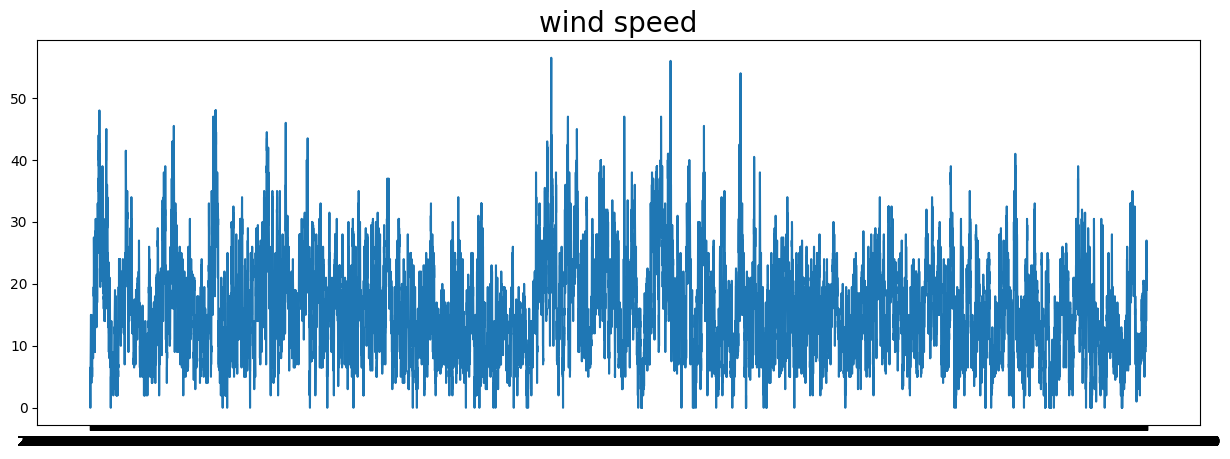

In [9]:
dates = londonmerged_data['timestamp'].values
temp  = londonmerged_data['wind_speed'].values


plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('wind speed',
          fontsize=20);

In [10]:
from sklearn.model_selection import train_test_split
date_latih, date_test, temp_latih, temp_test = train_test_split(dates, temp, test_size=0.2, shuffle=False)

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
train_set = windowed_dataset(temp_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(30, return_sequences=True,  input_shape=[None, 1]),
  tf.keras.layers.LSTM(30),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [13]:
minMae = (londonmerged_data['wind_speed'].max() - londonmerged_data['wind_speed'].min()) * 10/100
print(minMae)

5.65


In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<minMae) & (logs.get('val_mae')<minMae):
      print('\nMAE sudah mencapai <10%!')
      self.model.stop_training = True

callbacks = myCallback()


In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
    )
history = model.fit(
    train_set,
    epochs=200,
    validation_data=test_set,
    verbose=2,
    callbacks=[callbacks],
    )

Epoch 1/200
139/139 - 12s - loss: 15.8736 - mae: 16.3726 - val_loss: 12.7609 - val_mae: 13.2589 - 12s/epoch - 88ms/step
Epoch 2/200
139/139 - 7s - loss: 15.5796 - mae: 16.0791 - val_loss: 12.4397 - val_mae: 12.9390 - 7s/epoch - 53ms/step
Epoch 3/200
139/139 - 7s - loss: 15.1047 - mae: 15.6047 - val_loss: 11.7173 - val_mae: 12.2166 - 7s/epoch - 49ms/step
Epoch 4/200
139/139 - 6s - loss: 13.8895 - mae: 14.3873 - val_loss: 9.8549 - val_mae: 10.3495 - 6s/epoch - 47ms/step
Epoch 5/200
139/139 - 6s - loss: 10.1319 - mae: 10.6224 - val_loss: 5.2167 - val_mae: 5.6991 - 6s/epoch - 46ms/step
Epoch 6/200
139/139 - 7s - loss: 5.8214 - mae: 6.3051 - val_loss: 4.9548 - val_mae: 5.4391 - 7s/epoch - 50ms/step
Epoch 7/200

MAE sudah mencapai <10%!
139/139 - 7s - loss: 4.9020 - mae: 5.3813 - val_loss: 3.8992 - val_mae: 4.3784 - 7s/epoch - 48ms/step


In [18]:
# Mendapatkan riwayat pelatihan
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']



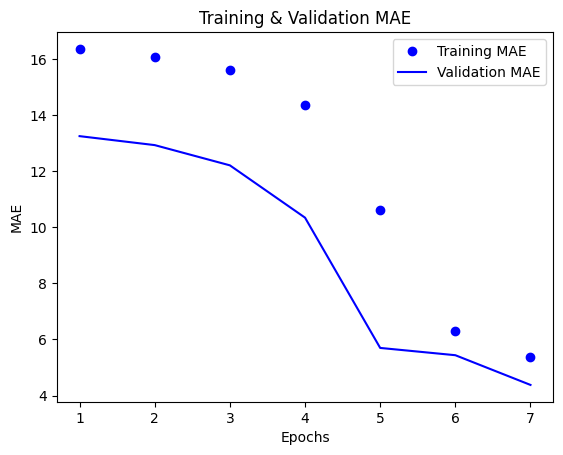

In [19]:
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training & Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


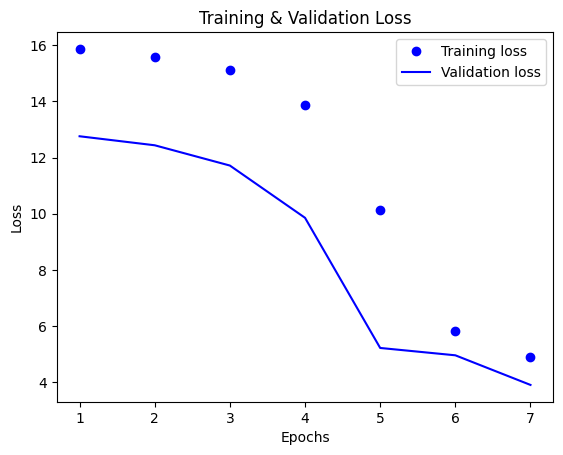

In [20]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()